In [1]:
from scripts.utils.settings import set_global_seed, get_device
from scripts.utils.data import DriverDrowsinessDataset, visualize_sequence
from scripts.utils.checks import check_dataset_for_nans, check_model_weights, calculate_model_size
from scripts.utils.augmentations import DrowsinessAugmentationPipeline, RandomZoom
from scripts.models.pretrained import VisionTransformerLSTM, TransformerTemporalModel, TemporalConvNet
from scripts.models.transformers import VisionTransformerWithTemporal
from scripts.training.adversarial import AdversarialAttack
from scripts.training.loss import FocalLoss
from scripts.training.train import train, evaluate
from scripts.evaluation.report import generate_detailed_classification_report
from scripts.evaluation.viz import plot_training_history

import os
import torch
import numpy as np
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import timm
from pprint import pprint

C:\Users\User\Desktop\Term 7\CV\2024_SUTD_CV_Final_Project\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
set_global_seed(
    seed = 42,
    deterministic = False,
    benchmark = False,
    use_cuda = True,
    use_mps = False
)

Global seed set to 42
Deterministic mode: False
CUDNN benchmark mode: False
Device configuration:
  CUDA available: True
  MPS available: False
  CUDA device count: 1
  Current CUDA device: 0


In [3]:
device = get_device()

Using CUDA: NVIDIA GeForce RTX 4090


In [4]:
avail_pretrained_models = timm.list_models(pretrained=True)
pprint(avail_pretrained_models)

['bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patch16_224.in1k_ft_in1k',
 'beitv2_large_patch16_224.in1k_ft_in22k',
 'beitv2_large_patch16_224.in1k_ft_in22k_in1k',
 'botnet26t_256.c1_in1k',
 'caformer_b36.sail_in1k',
 'caformer_b36.sail_in1k_384',
 'caformer_b36.sail_in22k',
 'caformer_b36.sail_in22k_ft_in1k',
 'caformer_b36.sail_in22k_ft_in1k_384',
 'caformer_m36.sail_in1k',
 'caformer_m36.sail_in1k_384',
 'caformer_m36.sail_in22k',
 'caformer_m36.sail_in22k_ft_in1k',
 'caformer_m36.sail_in22k_ft_in1k_384',
 'caformer_s18.sail_in1k',
 'caformer_s18.s

In [5]:
# Number of training epochs
num_epochs = 1 # 3 # Change to 6 for full training

# Set Adversary Learning
adversarial = True

# Initialise Model
# vit, deit, convnext - swin is too big - "swin_s3_tiny_224.ms_in1k"
# "vit_small_patch16_224", "deit3_small_patch16_224.fb_in1k", "convnextv2_pico.fcmae_ft_in1k", 
model_name = "vit_small_patch16_224"

# 'temporal_conv' 'transformer_temporal' 'vit_lstm'
architecture = 'vit_lstm'

In [6]:
# Parameters
model_name = "vit_small_patch16_224"
adversarial = True
num_epochs = 6
architecture = "temporal_conv"


In [7]:
ROOT_DIR = "./processed/rgb_face"

# Name of backbone
backbone = model_name.split("_")[0]

# Initialize DataLoaders with optimized parameters
batch_size = 8

if architecture == "vit_lstm":
    model_config = {
        "backbone": backbone,
        "num_classes": 2,  # Binary classification (e.g., positive/negative)
        "model_name": model_name,
        "use_temporal_modeling": True,
        "temporal_hidden_size": 512, # Reduced from 512
        "dropout": 0.5,
        "freeze_backbone": False,
        "rnn_num_layers": 2, # Redcued from 2
        "bidirectional": False,
        "pooling": "avg",
    }
elif architecture == "transformer_temporal":
    model_config = {
        "backbone": backbone,
        "num_classes": 2,  # Binary classification (e.g., positive/negative)
        "model_name": model_name,
        "num_frames": 16,
        "embed_dim": 512,
        "num_heads": 4,
        "num_layers": 1,
        "dropout": 0.1,
        "pooling": "avg",
    }
elif architecture == "temporal_conv":
    model_config = {
        "backbone": backbone,
        "num_classes": 2,  # Binary classification (e.g., positive/negative)
        "model_name": model_name,
        "num_frames": 16,
        "num_channels": [512, 256, 128],
        "kernel_size": 5,
        "dropout": 0.1,
        "pooling": "avg",
    }

print(model_config)

# Define adversary configuration
if adversarial:
    adversary_config = {
        "attack_type": "pgd",
        "epsilon": 0.03,
        "alpha": 0.01,
        "iters": 3,
        "emb_names": "all",
        "noise_var": 1e-5,
        "gamma": 1e-2
    }
else:
    adversary_config = None

checkpoint_dir = f"./checkpoints/{backbone}-{architecture}-adv-{adversarial}"
print(f"Checkpoint Directory: {checkpoint_dir}")

{'backbone': 'vit', 'num_classes': 2, 'model_name': 'vit_small_patch16_224', 'num_frames': 16, 'num_channels': [512, 256, 128], 'kernel_size': 5, 'dropout': 0.1, 'pooling': 'avg'}
Checkpoint Directory: ./checkpoints/vit-temporal_conv-adv-True


In [8]:
# Define enhanced training transform with data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip horizontally
    transforms.RandomRotation(degrees=15),  # Randomly rotate within ±15 degrees
    DrowsinessAugmentationPipeline(
        # blur_radius_range=(0, 1.0),     # Camera focus variations
        noise_factor=0.02,              # Camera sensor noise
        occlusion_prob=0.2,              # Probability to apply occlusion
        motion_blur_prob=0.3,            # Probability to apply motion blur
        noise_prob=0.2,                   # Probability to apply Gaussian noise
        sharpness_range=(0.8, 1.2),       # Range for sharpness adjustment
        sharpness_prob=0.3,               # Probability to apply sharpness adjustment
        colorfulness_range=(0.8, 1.2),    # Range for colorfulness (saturation) adjustment
        colorfulness_prob=0.3
    ),
    transforms.ColorJitter(  # Introduce variations in brightness, contrast, saturation, and hue
        brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1
    ),
    # RandomZoom(
    #     zoom_range=(0.8, 1.2),          # Center zoom range
    #     zoom_prob=0.3,                   # Probability to apply zoom
    # ),
    # transforms.RandomAffine(degrees=0, translate=(0.25, 0)),
    transforms.ToTensor(),  # Convert to tensor and rescale pixel values to [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Define validation and test transforms without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 pixels
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

In [9]:
# Initialize training dataset
train_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="train", 
    transform=train_transform,  # Apply data augmentation for training
    seq_len=16,  # Process sequences of length 16
    padding_value=0.0,  # Use 0.0 to pad incomplete sequences
    default_img_size=224,
    stride=8,
)

# Initialize validation dataset
val_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="val", 
    transform=val_test_transform,  # No augmentation for validation
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

# Initialize test dataset
test_dataset = DriverDrowsinessDataset(
    root_dir=ROOT_DIR, 
    split="test", 
    transform=val_test_transform,  # No augmentation for testing
    seq_len=16, 
    padding_value=0.0,
    default_img_size=224,
    stride=2,
)

In [10]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

7531 5409 8174


In [11]:
check_dataset_for_nans(train_dataset)
check_dataset_for_nans(val_dataset)
check_dataset_for_nans(test_dataset)

Checking for NaNs in dataset:   0%|                                          | 0/100 [00:00<?, ?it/s]

Checking for NaNs in dataset:   1%|▎                                 | 1/100 [00:00<00:17,  5.63it/s]

Checking for NaNs in dataset:   3%|█                                 | 3/100 [00:00<00:10,  8.93it/s]

Checking for NaNs in dataset:   5%|█▋                                | 5/100 [00:00<00:09, 10.28it/s]

Checking for NaNs in dataset:   7%|██▍                               | 7/100 [00:00<00:08, 11.04it/s]

Checking for NaNs in dataset:   9%|███                               | 9/100 [00:00<00:08, 11.17it/s]

Checking for NaNs in dataset:  11%|███▋                             | 11/100 [00:01<00:07, 11.33it/s]

Checking for NaNs in dataset:  13%|████▎                            | 13/100 [00:01<00:07, 12.12it/s]

Checking for NaNs in dataset:  15%|████▉                            | 15/100 [00:01<00:07, 11.79it/s]

Checking for NaNs in dataset:  17%|█████▌                           | 17/100 [00:01<00:07, 11.79it/s]

Checking for NaNs in dataset:  19%|██████▎                          | 19/100 [00:01<00:06, 11.58it/s]

Checking for NaNs in dataset:  21%|██████▉                          | 21/100 [00:01<00:06, 11.77it/s]

Checking for NaNs in dataset:  23%|███████▌                         | 23/100 [00:02<00:06, 12.01it/s]

Checking for NaNs in dataset:  25%|████████▎                        | 25/100 [00:02<00:06, 11.67it/s]

Checking for NaNs in dataset:  27%|████████▉                        | 27/100 [00:02<00:06, 11.80it/s]

Checking for NaNs in dataset:  29%|█████████▌                       | 29/100 [00:02<00:05, 12.51it/s]

Checking for NaNs in dataset:  31%|██████████▏                      | 31/100 [00:02<00:05, 11.78it/s]

Checking for NaNs in dataset:  33%|██████████▉                      | 33/100 [00:02<00:05, 11.77it/s]

Checking for NaNs in dataset:  35%|███████████▌                     | 35/100 [00:03<00:05, 11.83it/s]

Checking for NaNs in dataset:  37%|████████████▏                    | 37/100 [00:03<00:05, 11.78it/s]

Checking for NaNs in dataset:  39%|████████████▊                    | 39/100 [00:03<00:05, 11.73it/s]

Checking for NaNs in dataset:  41%|█████████████▌                   | 41/100 [00:03<00:05, 11.67it/s]

Checking for NaNs in dataset:  43%|██████████████▏                  | 43/100 [00:03<00:04, 11.85it/s]

Checking for NaNs in dataset:  45%|██████████████▊                  | 45/100 [00:03<00:04, 12.30it/s]

Checking for NaNs in dataset:  47%|███████████████▌                 | 47/100 [00:04<00:04, 12.27it/s]

Checking for NaNs in dataset:  49%|████████████████▏                | 49/100 [00:04<00:04, 12.10it/s]

Checking for NaNs in dataset:  51%|████████████████▊                | 51/100 [00:04<00:04, 11.93it/s]

Checking for NaNs in dataset:  53%|█████████████████▍               | 53/100 [00:04<00:03, 11.77it/s]

Checking for NaNs in dataset:  55%|██████████████████▏              | 55/100 [00:04<00:03, 11.39it/s]

Checking for NaNs in dataset:  57%|██████████████████▊              | 57/100 [00:04<00:03, 11.56it/s]

Checking for NaNs in dataset:  59%|███████████████████▍             | 59/100 [00:05<00:03, 11.83it/s]

Checking for NaNs in dataset:  61%|████████████████████▏            | 61/100 [00:05<00:03, 12.17it/s]

Checking for NaNs in dataset:  63%|████████████████████▊            | 63/100 [00:05<00:03, 11.92it/s]

Checking for NaNs in dataset:  65%|█████████████████████▍           | 65/100 [00:05<00:02, 12.04it/s]

Checking for NaNs in dataset:  67%|██████████████████████           | 67/100 [00:05<00:02, 12.02it/s]

Checking for NaNs in dataset:  69%|██████████████████████▊          | 69/100 [00:05<00:02, 11.83it/s]

Checking for NaNs in dataset:  71%|███████████████████████▍         | 71/100 [00:06<00:02, 11.82it/s]

Checking for NaNs in dataset:  73%|████████████████████████         | 73/100 [00:06<00:02, 11.89it/s]

Checking for NaNs in dataset:  75%|████████████████████████▊        | 75/100 [00:06<00:02, 12.19it/s]

Checking for NaNs in dataset:  77%|█████████████████████████▍       | 77/100 [00:06<00:01, 11.95it/s]

Checking for NaNs in dataset:  79%|██████████████████████████       | 79/100 [00:06<00:01, 11.64it/s]

Checking for NaNs in dataset:  81%|██████████████████████████▋      | 81/100 [00:06<00:01, 11.72it/s]

Checking for NaNs in dataset:  83%|███████████████████████████▍     | 83/100 [00:07<00:01, 11.93it/s]

Checking for NaNs in dataset:  85%|████████████████████████████     | 85/100 [00:07<00:01, 12.39it/s]

Checking for NaNs in dataset:  87%|████████████████████████████▋    | 87/100 [00:07<00:01, 12.02it/s]

Checking for NaNs in dataset:  89%|█████████████████████████████▎   | 89/100 [00:07<00:00, 11.71it/s]

Checking for NaNs in dataset:  91%|██████████████████████████████   | 91/100 [00:07<00:00, 11.38it/s]

Checking for NaNs in dataset:  93%|██████████████████████████████▋  | 93/100 [00:07<00:00, 11.44it/s]

Checking for NaNs in dataset:  95%|███████████████████████████████▎ | 95/100 [00:08<00:00, 11.57it/s]

Checking for NaNs in dataset:  97%|████████████████████████████████ | 97/100 [00:08<00:00, 11.75it/s]

Checking for NaNs in dataset:  99%|████████████████████████████████▋| 99/100 [00:08<00:00, 11.75it/s]

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:08<00:00, 11.73it/s]

No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset:   0%|                                          | 0/100 [00:00<?, ?it/s]

Checking for NaNs in dataset:   4%|█▎                                | 4/100 [00:00<00:02, 39.41it/s]

Checking for NaNs in dataset:   9%|███                               | 9/100 [00:00<00:02, 42.37it/s]

Checking for NaNs in dataset:  14%|████▌                            | 14/100 [00:00<00:01, 43.29it/s]

Checking for NaNs in dataset:  19%|██████▎                          | 19/100 [00:00<00:01, 43.37it/s]

Checking for NaNs in dataset:  24%|███████▉                         | 24/100 [00:00<00:01, 43.56it/s]

Checking for NaNs in dataset:  29%|█████████▌                       | 29/100 [00:00<00:01, 42.81it/s]

Checking for NaNs in dataset:  34%|███████████▏                     | 34/100 [00:00<00:01, 42.99it/s]

Checking for NaNs in dataset:  39%|████████████▊                    | 39/100 [00:00<00:01, 42.89it/s]

Checking for NaNs in dataset:  44%|██████████████▌                  | 44/100 [00:01<00:01, 43.44it/s]

Checking for NaNs in dataset:  49%|████████████████▏                | 49/100 [00:01<00:01, 43.48it/s]

Checking for NaNs in dataset:  54%|█████████████████▊               | 54/100 [00:01<00:01, 43.75it/s]

Checking for NaNs in dataset:  59%|███████████████████▍             | 59/100 [00:01<00:00, 43.94it/s]

Checking for NaNs in dataset:  64%|█████████████████████            | 64/100 [00:01<00:00, 44.48it/s]

Checking for NaNs in dataset:  69%|██████████████████████▊          | 69/100 [00:01<00:00, 43.97it/s]

Checking for NaNs in dataset:  74%|████████████████████████▍        | 74/100 [00:01<00:00, 44.03it/s]

Checking for NaNs in dataset:  79%|██████████████████████████       | 79/100 [00:01<00:00, 44.28it/s]

Checking for NaNs in dataset:  84%|███████████████████████████▋     | 84/100 [00:01<00:00, 45.46it/s]

Checking for NaNs in dataset:  91%|██████████████████████████████   | 91/100 [00:02<00:00, 50.02it/s]

Checking for NaNs in dataset:  96%|███████████████████████████████▋ | 96/100 [00:02<00:00, 48.32it/s]

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:02<00:00, 44.73it/s]

No NaNs or Infs found in the dataset samples checked.


Checking for NaNs in dataset:   0%|                                          | 0/100 [00:00<?, ?it/s]

Checking for NaNs in dataset:   5%|█▋                                | 5/100 [00:00<00:02, 42.16it/s]

Checking for NaNs in dataset:  10%|███▎                             | 10/100 [00:00<00:02, 43.11it/s]

Checking for NaNs in dataset:  15%|████▉                            | 15/100 [00:00<00:01, 43.28it/s]

Checking for NaNs in dataset:  20%|██████▌                          | 20/100 [00:00<00:01, 43.19it/s]

Checking for NaNs in dataset:  25%|████████▎                        | 25/100 [00:00<00:01, 42.97it/s]

Checking for NaNs in dataset:  30%|█████████▉                       | 30/100 [00:00<00:01, 42.86it/s]

Checking for NaNs in dataset:  35%|███████████▌                     | 35/100 [00:00<00:01, 43.17it/s]

Checking for NaNs in dataset:  40%|█████████████▏                   | 40/100 [00:00<00:01, 43.54it/s]

Checking for NaNs in dataset:  45%|██████████████▊                  | 45/100 [00:01<00:01, 43.64it/s]

Checking for NaNs in dataset:  50%|████████████████▌                | 50/100 [00:01<00:01, 43.83it/s]

Checking for NaNs in dataset:  55%|██████████████████▏              | 55/100 [00:01<00:01, 44.00it/s]

Checking for NaNs in dataset:  60%|███████████████████▊             | 60/100 [00:01<00:00, 43.90it/s]

Checking for NaNs in dataset:  65%|█████████████████████▍           | 65/100 [00:01<00:00, 44.09it/s]

Checking for NaNs in dataset:  70%|███████████████████████          | 70/100 [00:01<00:00, 44.04it/s]

Checking for NaNs in dataset:  75%|████████████████████████▊        | 75/100 [00:01<00:00, 44.39it/s]

Checking for NaNs in dataset:  80%|██████████████████████████▍      | 80/100 [00:01<00:00, 44.12it/s]

Checking for NaNs in dataset:  85%|████████████████████████████     | 85/100 [00:01<00:00, 44.33it/s]

Checking for NaNs in dataset:  92%|██████████████████████████████▎  | 92/100 [00:02<00:00, 48.90it/s]

Checking for NaNs in dataset:  97%|████████████████████████████████ | 97/100 [00:02<00:00, 47.73it/s]

Checking for NaNs in dataset: 100%|████████████████████████████████| 100/100 [00:02<00:00, 44.63it/s]

No NaNs or Infs found in the dataset samples checked.


True

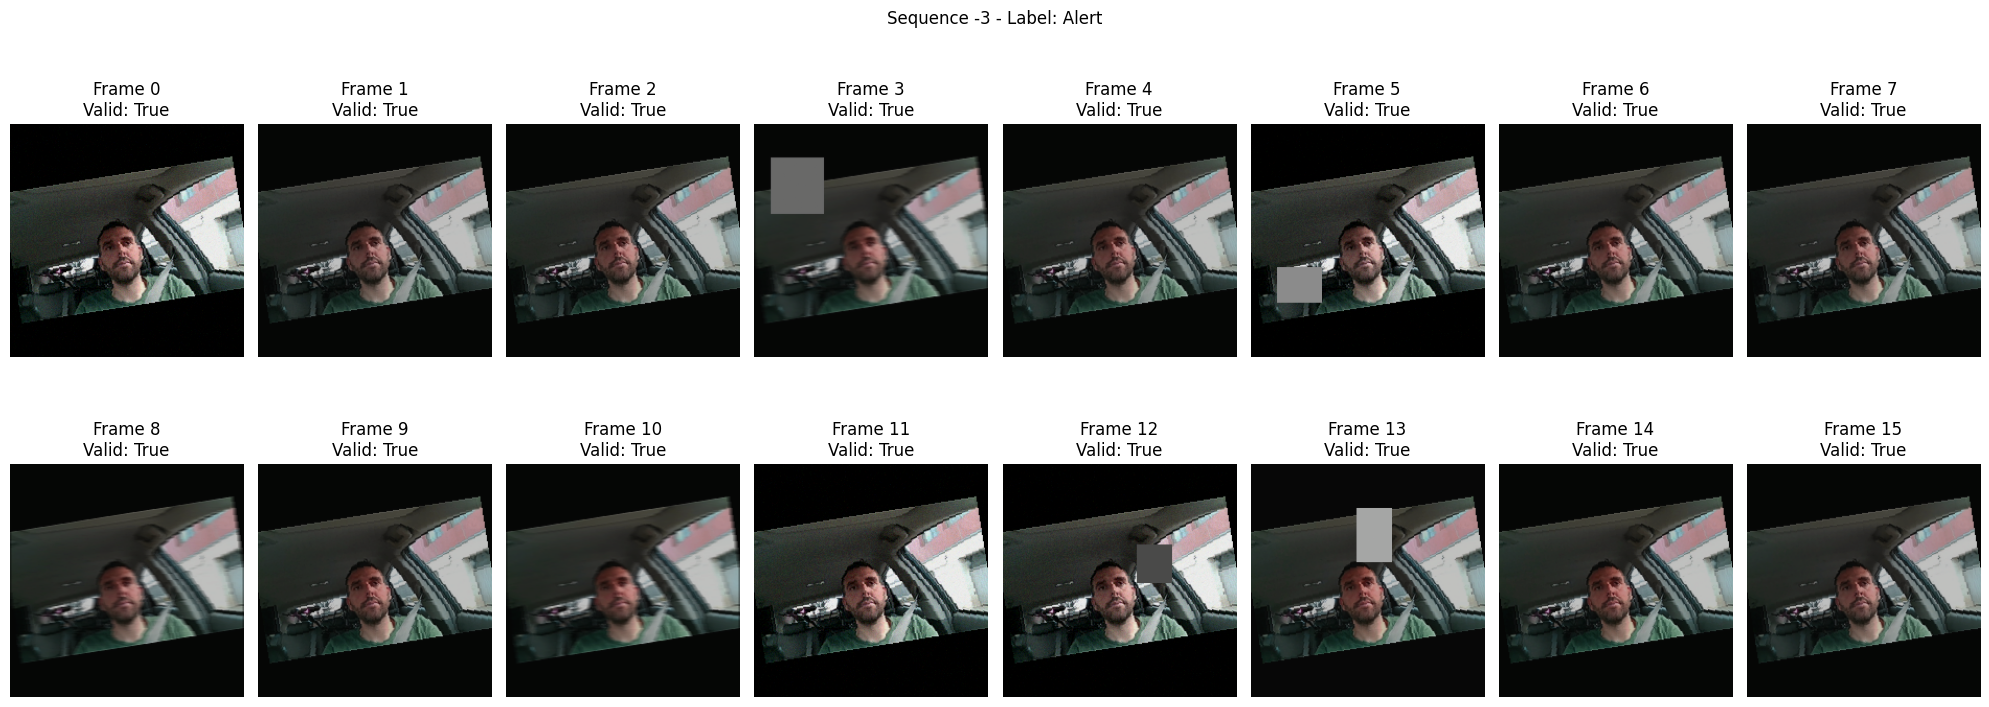

In [12]:
visualize_sequence(train_dataset, idx=-3)

In [13]:
# Step 1: Extract labels directly from the dataset
labels = np.array([train_dataset[i][2] for i in tqdm(range(len(train_dataset)))])  # Access the labels efficiently

# Step 2: Compute class weights
unique_classes = np.unique(labels)
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=unique_classes, 
    y=labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
class_weights = class_weights * (1 / class_weights[0])

# Step 3: Map class weights to sample weights
label_to_weight = {label: weight for label, weight in zip(unique_classes, class_weights)}
sample_weights = torch.tensor([label_to_weight[label] for label in labels], dtype=torch.float)

# Step 4: Create the WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Match the total number of samples
    replacement=True  # Replacement ensures balanced sampling
)

print("Class weights:", class_weights)

  0%|                                                                       | 0/7531 [00:00<?, ?it/s]

  0%|                                                               | 2/7531 [00:00<10:24, 12.06it/s]

  0%|                                                               | 4/7531 [00:00<10:16, 12.22it/s]

  0%|                                                               | 6/7531 [00:00<09:48, 12.79it/s]

  0%|                                                               | 8/7531 [00:00<09:51, 12.73it/s]

  0%|                                                              | 10/7531 [00:00<10:03, 12.47it/s]

  0%|                                                              | 12/7531 [00:00<10:16, 12.20it/s]

  0%|                                                              | 14/7531 [00:01<09:40, 12.96it/s]

  0%|▏                                                             | 16/7531 [00:01<09:41, 12.91it/s]

  0%|▏                                                             | 18/7531 [00:01<10:11, 12.28it/s]

  0%|▏                                                             | 20/7531 [00:01<10:14, 12.22it/s]

  0%|▏                                                             | 22/7531 [00:01<09:52, 12.68it/s]

  0%|▏                                                             | 24/7531 [00:01<09:59, 12.52it/s]

  0%|▏                                                             | 26/7531 [00:02<10:09, 12.30it/s]

  0%|▏                                                             | 28/7531 [00:02<10:13, 12.23it/s]

  0%|▏                                                             | 30/7531 [00:02<10:05, 12.39it/s]

  0%|▎                                                             | 32/7531 [00:02<10:07, 12.35it/s]

  0%|▎                                                             | 34/7531 [00:02<10:08, 12.32it/s]

  0%|▎                                                             | 36/7531 [00:02<10:10, 12.28it/s]

  1%|▎                                                             | 38/7531 [00:03<10:12, 12.24it/s]

  1%|▎                                                             | 40/7531 [00:03<10:13, 12.21it/s]

  1%|▎                                                             | 42/7531 [00:03<10:02, 12.43it/s]

  1%|▎                                                             | 44/7531 [00:03<09:27, 13.18it/s]

  1%|▍                                                             | 46/7531 [00:03<09:40, 12.89it/s]

  1%|▍                                                             | 48/7531 [00:03<09:39, 12.90it/s]

  1%|▍                                                             | 50/7531 [00:03<09:45, 12.77it/s]

  1%|▍                                                             | 52/7531 [00:04<09:47, 12.74it/s]

  1%|▍                                                             | 54/7531 [00:04<09:49, 12.68it/s]

  1%|▍                                                             | 56/7531 [00:04<09:38, 12.93it/s]

  1%|▍                                                             | 58/7531 [00:04<09:42, 12.83it/s]

  1%|▍                                                             | 60/7531 [00:04<09:53, 12.59it/s]

  1%|▌                                                             | 62/7531 [00:04<09:51, 12.62it/s]

  1%|▌                                                             | 64/7531 [00:05<09:37, 12.94it/s]

  1%|▌                                                             | 66/7531 [00:05<09:28, 13.12it/s]

  1%|▌                                                             | 68/7531 [00:05<09:40, 12.86it/s]

  1%|▌                                                             | 70/7531 [00:05<09:51, 12.61it/s]

  1%|▌                                                             | 72/7531 [00:05<09:47, 12.70it/s]

  1%|▌                                                             | 74/7531 [00:05<09:36, 12.94it/s]

  1%|▋                                                             | 76/7531 [00:06<09:47, 12.68it/s]

  1%|▋                                                             | 78/7531 [00:06<09:50, 12.62it/s]

  1%|▋                                                             | 80/7531 [00:06<09:37, 12.90it/s]

  1%|▋                                                             | 82/7531 [00:06<09:28, 13.11it/s]

  1%|▋                                                             | 84/7531 [00:06<09:25, 13.16it/s]

  1%|▋                                                             | 86/7531 [00:06<09:28, 13.09it/s]

  1%|▋                                                             | 88/7531 [00:06<09:18, 13.32it/s]

  1%|▋                                                             | 90/7531 [00:07<09:16, 13.36it/s]

  1%|▊                                                             | 92/7531 [00:07<09:12, 13.46it/s]

  1%|▊                                                             | 94/7531 [00:07<09:09, 13.54it/s]

  1%|▊                                                             | 96/7531 [00:07<09:19, 13.29it/s]

  1%|▊                                                             | 98/7531 [00:07<09:39, 12.82it/s]

  1%|▊                                                            | 100/7531 [00:07<09:36, 12.90it/s]

  1%|▊                                                            | 102/7531 [00:08<09:48, 12.62it/s]

  1%|▊                                                            | 104/7531 [00:08<09:55, 12.47it/s]

  1%|▊                                                            | 106/7531 [00:08<10:16, 12.05it/s]

  1%|▊                                                            | 108/7531 [00:08<10:00, 12.36it/s]

  1%|▉                                                            | 110/7531 [00:08<09:53, 12.50it/s]

  1%|▉                                                            | 112/7531 [00:08<10:15, 12.04it/s]

  2%|▉                                                            | 114/7531 [00:09<10:18, 12.00it/s]

  2%|▉                                                            | 116/7531 [00:09<10:03, 12.30it/s]

  2%|▉                                                            | 118/7531 [00:09<09:56, 12.43it/s]

  2%|▉                                                            | 120/7531 [00:09<10:09, 12.16it/s]

  2%|▉                                                            | 122/7531 [00:09<10:02, 12.29it/s]

  2%|█                                                            | 124/7531 [00:09<09:51, 12.52it/s]

  2%|█                                                            | 126/7531 [00:09<10:02, 12.29it/s]

  2%|█                                                            | 128/7531 [00:10<10:10, 12.13it/s]

  2%|█                                                            | 130/7531 [00:10<10:20, 11.93it/s]

  2%|█                                                            | 132/7531 [00:10<10:38, 11.58it/s]

  2%|█                                                            | 134/7531 [00:10<10:38, 11.59it/s]

  2%|█                                                            | 136/7531 [00:10<10:27, 11.79it/s]

  2%|█                                                            | 138/7531 [00:11<10:28, 11.77it/s]

  2%|█▏                                                           | 140/7531 [00:11<10:22, 11.86it/s]

  2%|█▏                                                           | 142/7531 [00:11<10:04, 12.23it/s]

  2%|█▏                                                           | 144/7531 [00:11<10:20, 11.90it/s]

  2%|█▏                                                           | 146/7531 [00:11<10:19, 11.93it/s]

  2%|█▏                                                           | 148/7531 [00:11<10:00, 12.29it/s]

  2%|█▏                                                           | 150/7531 [00:11<10:09, 12.11it/s]

  2%|█▏                                                           | 152/7531 [00:12<10:10, 12.10it/s]

  2%|█▏                                                           | 154/7531 [00:12<10:15, 11.98it/s]

  2%|█▎                                                           | 156/7531 [00:12<10:22, 11.84it/s]

  2%|█▎                                                           | 158/7531 [00:12<10:04, 12.20it/s]

  2%|█▎                                                           | 160/7531 [00:12<10:24, 11.81it/s]

  2%|█▎                                                           | 162/7531 [00:12<10:07, 12.13it/s]

  2%|█▎                                                           | 164/7531 [00:13<10:03, 12.21it/s]

  2%|█▎                                                           | 166/7531 [00:13<10:03, 12.20it/s]

  2%|█▎                                                           | 168/7531 [00:13<09:46, 12.56it/s]

  2%|█▍                                                           | 170/7531 [00:13<09:56, 12.34it/s]

  2%|█▍                                                           | 172/7531 [00:13<09:50, 12.46it/s]

  2%|█▍                                                           | 174/7531 [00:13<10:05, 12.15it/s]

  2%|█▍                                                           | 176/7531 [00:14<10:19, 11.87it/s]

  2%|█▍                                                           | 178/7531 [00:14<10:18, 11.88it/s]

  2%|█▍                                                           | 180/7531 [00:14<10:18, 11.89it/s]

  2%|█▍                                                           | 182/7531 [00:14<10:18, 11.87it/s]

  2%|█▍                                                           | 184/7531 [00:14<10:12, 11.99it/s]

  2%|█▌                                                           | 186/7531 [00:14<09:44, 12.57it/s]

  2%|█▌                                                           | 188/7531 [00:15<10:01, 12.21it/s]

  3%|█▌                                                           | 190/7531 [00:15<09:57, 12.29it/s]

  3%|█▌                                                           | 192/7531 [00:15<10:01, 12.21it/s]

  3%|█▌                                                           | 194/7531 [00:15<10:13, 11.95it/s]

  3%|█▌                                                           | 196/7531 [00:15<10:15, 11.91it/s]

  3%|█▌                                                           | 198/7531 [00:15<10:09, 12.04it/s]

  3%|█▌                                                           | 200/7531 [00:16<10:18, 11.86it/s]

  3%|█▋                                                           | 202/7531 [00:16<10:06, 12.09it/s]

  3%|█▋                                                           | 204/7531 [00:16<09:52, 12.37it/s]

  3%|█▋                                                           | 206/7531 [00:16<09:30, 12.85it/s]

  3%|█▋                                                           | 208/7531 [00:16<09:33, 12.77it/s]

  3%|█▋                                                           | 210/7531 [00:16<09:24, 12.96it/s]

  3%|█▋                                                           | 212/7531 [00:17<08:36, 14.17it/s]

  3%|█▋                                                           | 214/7531 [00:17<09:16, 13.14it/s]

  3%|█▋                                                           | 216/7531 [00:17<09:23, 12.99it/s]

  3%|█▊                                                           | 218/7531 [00:17<09:39, 12.62it/s]

  3%|█▊                                                           | 220/7531 [00:17<09:55, 12.28it/s]

  3%|█▊                                                           | 222/7531 [00:17<10:00, 12.17it/s]

  3%|█▊                                                           | 224/7531 [00:18<10:03, 12.12it/s]

  3%|█▊                                                           | 226/7531 [00:18<10:07, 12.03it/s]

  3%|█▊                                                           | 228/7531 [00:18<10:21, 11.75it/s]

  3%|█▊                                                           | 230/7531 [00:18<10:24, 11.70it/s]

  3%|█▉                                                           | 232/7531 [00:18<10:03, 12.10it/s]

  3%|█▉                                                           | 234/7531 [00:18<09:27, 12.85it/s]

  3%|█▉                                                           | 236/7531 [00:19<09:56, 12.23it/s]

  3%|█▉                                                           | 238/7531 [00:19<09:43, 12.49it/s]

  3%|█▉                                                           | 240/7531 [00:19<09:54, 12.27it/s]

  3%|█▉                                                           | 242/7531 [00:19<09:48, 12.39it/s]

  3%|█▉                                                           | 244/7531 [00:19<09:56, 12.21it/s]

  3%|█▉                                                           | 246/7531 [00:19<09:39, 12.57it/s]

  3%|██                                                           | 248/7531 [00:19<09:43, 12.47it/s]

  3%|██                                                           | 250/7531 [00:20<09:47, 12.40it/s]

  3%|██                                                           | 252/7531 [00:20<09:43, 12.48it/s]

  3%|██                                                           | 254/7531 [00:20<09:55, 12.22it/s]

  3%|██                                                           | 256/7531 [00:20<10:09, 11.93it/s]

  3%|██                                                           | 258/7531 [00:20<10:18, 11.76it/s]

  3%|██                                                           | 260/7531 [00:20<10:15, 11.81it/s]

  3%|██                                                           | 262/7531 [00:21<10:13, 11.84it/s]

  4%|██▏                                                          | 264/7531 [00:21<09:59, 12.13it/s]

  4%|██▏                                                          | 266/7531 [00:21<09:54, 12.22it/s]

  4%|██▏                                                          | 268/7531 [00:21<09:11, 13.16it/s]

  4%|██▏                                                          | 270/7531 [00:21<09:43, 12.45it/s]

  4%|██▏                                                          | 272/7531 [00:21<09:42, 12.46it/s]

  4%|██▏                                                          | 274/7531 [00:22<09:50, 12.29it/s]

  4%|██▏                                                          | 276/7531 [00:22<09:50, 12.29it/s]

  4%|██▎                                                          | 278/7531 [00:22<10:15, 11.79it/s]

  4%|██▎                                                          | 280/7531 [00:22<10:13, 11.81it/s]

  4%|██▎                                                          | 282/7531 [00:22<10:11, 11.86it/s]

  4%|██▎                                                          | 284/7531 [00:22<10:16, 11.75it/s]

  4%|██▎                                                          | 286/7531 [00:23<10:12, 11.83it/s]

  4%|██▎                                                          | 288/7531 [00:23<10:19, 11.69it/s]

  4%|██▎                                                          | 290/7531 [00:23<10:17, 11.72it/s]

  4%|██▎                                                          | 292/7531 [00:23<10:19, 11.68it/s]

  4%|██▍                                                          | 294/7531 [00:23<10:25, 11.57it/s]

  4%|██▍                                                          | 296/7531 [00:23<10:21, 11.63it/s]

  4%|██▍                                                          | 298/7531 [00:24<10:00, 12.05it/s]

  4%|██▍                                                          | 300/7531 [00:24<09:58, 12.09it/s]

  4%|██▍                                                          | 302/7531 [00:24<10:08, 11.89it/s]

  4%|██▍                                                          | 304/7531 [00:24<09:42, 12.40it/s]

  4%|██▍                                                          | 306/7531 [00:24<09:57, 12.09it/s]

  4%|██▍                                                          | 308/7531 [00:24<10:00, 12.02it/s]

  4%|██▌                                                          | 310/7531 [00:25<09:57, 12.08it/s]

  4%|██▌                                                          | 312/7531 [00:25<10:09, 11.85it/s]

  4%|██▌                                                          | 314/7531 [00:25<10:14, 11.74it/s]

  4%|██▌                                                          | 316/7531 [00:25<09:53, 12.16it/s]

  4%|██▌                                                          | 318/7531 [00:25<09:47, 12.28it/s]

  4%|██▌                                                          | 320/7531 [00:25<08:57, 13.42it/s]

  4%|██▌                                                          | 322/7531 [00:26<09:13, 13.02it/s]

  4%|██▌                                                          | 324/7531 [00:26<09:32, 12.60it/s]

  4%|██▋                                                          | 326/7531 [00:26<09:31, 12.60it/s]

  4%|██▋                                                          | 328/7531 [00:26<09:32, 12.57it/s]

  4%|██▋                                                          | 330/7531 [00:26<09:51, 12.18it/s]

  4%|██▋                                                          | 332/7531 [00:26<09:52, 12.15it/s]

  4%|██▋                                                          | 334/7531 [00:27<10:04, 11.90it/s]

  4%|██▋                                                          | 336/7531 [00:27<09:31, 12.59it/s]

  4%|██▋                                                          | 338/7531 [00:27<09:34, 12.53it/s]

  5%|██▊                                                          | 340/7531 [00:27<09:41, 12.37it/s]

  5%|██▊                                                          | 342/7531 [00:27<09:37, 12.45it/s]

  5%|██▊                                                          | 344/7531 [00:27<09:25, 12.70it/s]

  5%|██▊                                                          | 346/7531 [00:28<09:44, 12.30it/s]

  5%|██▊                                                          | 348/7531 [00:28<09:46, 12.25it/s]

  5%|██▊                                                          | 350/7531 [00:28<09:51, 12.15it/s]

  5%|██▊                                                          | 352/7531 [00:28<09:15, 12.91it/s]

  5%|██▊                                                          | 354/7531 [00:28<09:39, 12.38it/s]

  5%|██▉                                                          | 356/7531 [00:28<09:33, 12.52it/s]

  5%|██▉                                                          | 358/7531 [00:29<10:01, 11.93it/s]

  5%|██▉                                                          | 360/7531 [00:29<09:56, 12.03it/s]

  5%|██▉                                                          | 362/7531 [00:29<09:44, 12.26it/s]

  5%|██▉                                                          | 364/7531 [00:29<09:49, 12.16it/s]

  5%|██▉                                                          | 366/7531 [00:29<09:59, 11.95it/s]

  5%|██▉                                                          | 368/7531 [00:29<09:47, 12.18it/s]

  5%|██▉                                                          | 370/7531 [00:29<09:31, 12.53it/s]

  5%|███                                                          | 372/7531 [00:30<09:34, 12.46it/s]

  5%|███                                                          | 374/7531 [00:30<09:47, 12.18it/s]

  5%|███                                                          | 376/7531 [00:30<09:40, 12.32it/s]

  5%|███                                                          | 378/7531 [00:30<09:46, 12.19it/s]

  5%|███                                                          | 380/7531 [00:30<09:41, 12.29it/s]

  5%|███                                                          | 382/7531 [00:30<09:54, 12.03it/s]

  5%|███                                                          | 384/7531 [00:31<10:00, 11.89it/s]

  5%|███▏                                                         | 386/7531 [00:31<10:03, 11.85it/s]

  5%|███▏                                                         | 388/7531 [00:31<10:17, 11.57it/s]

  5%|███▏                                                         | 390/7531 [00:31<10:01, 11.88it/s]

  5%|███▏                                                         | 392/7531 [00:31<10:12, 11.65it/s]

  5%|███▏                                                         | 394/7531 [00:31<09:41, 12.28it/s]

  5%|███▏                                                         | 396/7531 [00:32<09:33, 12.45it/s]

  5%|███▏                                                         | 398/7531 [00:32<09:25, 12.61it/s]

  5%|███▏                                                         | 400/7531 [00:32<09:40, 12.28it/s]

  5%|███▎                                                         | 402/7531 [00:32<09:42, 12.23it/s]

  5%|███▎                                                         | 404/7531 [00:32<09:42, 12.23it/s]

  5%|███▎                                                         | 406/7531 [00:32<10:02, 11.83it/s]

  5%|███▎                                                         | 408/7531 [00:33<10:06, 11.75it/s]

  5%|███▎                                                         | 410/7531 [00:33<10:00, 11.85it/s]

  5%|███▎                                                         | 412/7531 [00:33<09:45, 12.15it/s]

  5%|███▎                                                         | 414/7531 [00:33<09:07, 13.00it/s]

  6%|███▎                                                         | 416/7531 [00:33<09:26, 12.55it/s]

  6%|███▍                                                         | 418/7531 [00:33<09:30, 12.46it/s]

  6%|███▍                                                         | 420/7531 [00:34<09:49, 12.07it/s]

  6%|███▍                                                         | 422/7531 [00:34<09:49, 12.05it/s]

  6%|███▍                                                         | 424/7531 [00:34<09:44, 12.16it/s]

  6%|███▍                                                         | 426/7531 [00:34<09:40, 12.24it/s]

  6%|███▍                                                         | 428/7531 [00:34<09:36, 12.33it/s]

  6%|███▍                                                         | 430/7531 [00:34<09:46, 12.12it/s]

  6%|███▍                                                         | 432/7531 [00:35<09:57, 11.87it/s]

  6%|███▌                                                         | 434/7531 [00:35<09:26, 12.53it/s]

  6%|███▌                                                         | 436/7531 [00:35<09:43, 12.15it/s]

  6%|███▌                                                         | 438/7531 [00:35<09:58, 11.85it/s]

  6%|███▌                                                         | 440/7531 [00:35<10:10, 11.61it/s]

  6%|███▌                                                         | 442/7531 [00:35<10:23, 11.37it/s]

  6%|███▌                                                         | 444/7531 [00:36<11:11, 10.55it/s]

  6%|███▌                                                         | 446/7531 [00:36<11:34, 10.20it/s]

  6%|███▋                                                         | 448/7531 [00:36<11:14, 10.50it/s]

  6%|███▋                                                         | 450/7531 [00:36<10:52, 10.86it/s]

  6%|███▋                                                         | 452/7531 [00:36<10:34, 11.16it/s]

  6%|███▋                                                         | 454/7531 [00:37<10:17, 11.46it/s]

  6%|███▋                                                         | 456/7531 [00:37<10:11, 11.58it/s]

  6%|███▋                                                         | 458/7531 [00:37<09:27, 12.47it/s]

  6%|███▋                                                         | 460/7531 [00:37<09:25, 12.51it/s]

  6%|███▋                                                         | 462/7531 [00:37<09:53, 11.91it/s]

  6%|███▊                                                         | 464/7531 [00:37<09:43, 12.12it/s]

  6%|███▊                                                         | 466/7531 [00:38<09:40, 12.17it/s]

  6%|███▊                                                         | 468/7531 [00:38<09:58, 11.81it/s]

  6%|███▊                                                         | 470/7531 [00:38<10:13, 11.51it/s]

  6%|███▊                                                         | 472/7531 [00:38<10:09, 11.58it/s]

  6%|███▊                                                         | 474/7531 [00:38<09:53, 11.90it/s]

  6%|███▊                                                         | 476/7531 [00:38<09:55, 11.85it/s]

  6%|███▊                                                         | 478/7531 [00:39<09:55, 11.85it/s]

  6%|███▉                                                         | 480/7531 [00:39<09:51, 11.92it/s]

  6%|███▉                                                         | 482/7531 [00:39<09:48, 11.97it/s]

  6%|███▉                                                         | 484/7531 [00:39<10:02, 11.69it/s]

  6%|███▉                                                         | 486/7531 [00:39<09:45, 12.03it/s]

  6%|███▉                                                         | 488/7531 [00:39<09:48, 11.98it/s]

  7%|███▉                                                         | 490/7531 [00:40<10:02, 11.69it/s]

  7%|███▉                                                         | 492/7531 [00:40<09:44, 12.04it/s]

  7%|████                                                         | 494/7531 [00:40<09:53, 11.85it/s]

  7%|████                                                         | 496/7531 [00:40<10:07, 11.57it/s]

  7%|████                                                         | 498/7531 [00:40<10:24, 11.26it/s]

  7%|████                                                         | 500/7531 [00:40<10:28, 11.18it/s]

  7%|████                                                         | 502/7531 [00:41<10:14, 11.43it/s]

  7%|████                                                         | 504/7531 [00:41<10:14, 11.44it/s]

  7%|████                                                         | 506/7531 [00:41<10:10, 11.50it/s]

  7%|████                                                         | 508/7531 [00:41<10:16, 11.39it/s]

  7%|████▏                                                        | 510/7531 [00:41<09:52, 11.85it/s]

  7%|████▏                                                        | 512/7531 [00:41<09:56, 11.76it/s]

  7%|████▏                                                        | 514/7531 [00:42<09:21, 12.50it/s]

  7%|████▏                                                        | 516/7531 [00:42<10:00, 11.68it/s]

  7%|████▏                                                        | 518/7531 [00:42<09:44, 11.99it/s]

  7%|████▏                                                        | 520/7531 [00:42<09:41, 12.05it/s]

  7%|████▏                                                        | 522/7531 [00:42<09:52, 11.83it/s]

  7%|████▏                                                        | 524/7531 [00:42<09:56, 11.75it/s]

  7%|████▎                                                        | 526/7531 [00:43<09:57, 11.72it/s]

  7%|████▎                                                        | 528/7531 [00:43<09:42, 12.02it/s]

  7%|████▎                                                        | 530/7531 [00:43<09:54, 11.77it/s]

  7%|████▎                                                        | 532/7531 [00:43<10:07, 11.53it/s]

  7%|████▎                                                        | 534/7531 [00:43<09:55, 11.74it/s]

  7%|████▎                                                        | 536/7531 [00:44<10:05, 11.54it/s]

  7%|████▎                                                        | 538/7531 [00:44<09:31, 12.23it/s]

  7%|████▎                                                        | 540/7531 [00:44<09:35, 12.16it/s]

  7%|████▍                                                        | 542/7531 [00:44<09:40, 12.04it/s]

  7%|████▍                                                        | 544/7531 [00:44<09:33, 12.18it/s]

  7%|████▍                                                        | 546/7531 [00:44<09:48, 11.88it/s]

  7%|████▍                                                        | 548/7531 [00:45<09:46, 11.90it/s]

  7%|████▍                                                        | 550/7531 [00:45<09:46, 11.91it/s]

  7%|████▍                                                        | 552/7531 [00:45<09:57, 11.69it/s]

  7%|████▍                                                        | 554/7531 [00:45<09:53, 11.76it/s]

  7%|████▌                                                        | 556/7531 [00:45<09:54, 11.73it/s]

  7%|████▌                                                        | 558/7531 [00:45<09:35, 12.11it/s]

  7%|████▌                                                        | 560/7531 [00:46<09:36, 12.10it/s]

  7%|████▌                                                        | 562/7531 [00:46<09:35, 12.11it/s]

  7%|████▌                                                        | 564/7531 [00:46<09:20, 12.43it/s]

  8%|████▌                                                        | 566/7531 [00:46<09:28, 12.26it/s]

  8%|████▌                                                        | 568/7531 [00:46<09:27, 12.28it/s]

  8%|████▌                                                        | 570/7531 [00:46<09:31, 12.18it/s]

  8%|████▋                                                        | 572/7531 [00:46<09:40, 11.99it/s]

  8%|████▋                                                        | 574/7531 [00:47<09:45, 11.87it/s]

  8%|████▋                                                        | 576/7531 [00:47<09:47, 11.84it/s]

  8%|████▋                                                        | 578/7531 [00:47<09:17, 12.47it/s]

  8%|████▋                                                        | 580/7531 [00:47<09:21, 12.38it/s]

  8%|████▋                                                        | 582/7531 [00:47<09:20, 12.40it/s]

  8%|████▋                                                        | 584/7531 [00:47<09:35, 12.06it/s]

  8%|████▋                                                        | 586/7531 [00:48<08:44, 13.25it/s]

  8%|████▊                                                        | 588/7531 [00:48<09:18, 12.44it/s]

  8%|████▊                                                        | 590/7531 [00:48<09:24, 12.30it/s]

  8%|████▊                                                        | 592/7531 [00:48<09:40, 11.94it/s]

  8%|████▊                                                        | 594/7531 [00:48<09:39, 11.97it/s]

  8%|████▊                                                        | 596/7531 [00:48<09:33, 12.09it/s]

  8%|████▊                                                        | 598/7531 [00:49<09:23, 12.30it/s]

  8%|████▊                                                        | 600/7531 [00:49<09:31, 12.13it/s]

  8%|████▉                                                        | 602/7531 [00:49<09:36, 12.01it/s]

  8%|████▉                                                        | 604/7531 [00:49<08:39, 13.34it/s]

  8%|████▉                                                        | 606/7531 [00:49<08:45, 13.19it/s]

  8%|████▉                                                        | 608/7531 [00:49<09:08, 12.62it/s]

  8%|████▉                                                        | 610/7531 [00:50<09:04, 12.70it/s]

  8%|████▉                                                        | 612/7531 [00:50<09:14, 12.47it/s]

  8%|████▉                                                        | 614/7531 [00:50<09:27, 12.19it/s]

  8%|████▉                                                        | 616/7531 [00:50<09:23, 12.28it/s]

  8%|█████                                                        | 618/7531 [00:50<09:23, 12.27it/s]

  8%|█████                                                        | 620/7531 [00:50<09:25, 12.22it/s]

  8%|█████                                                        | 622/7531 [00:51<09:24, 12.23it/s]

  8%|█████                                                        | 624/7531 [00:51<09:37, 11.96it/s]

  8%|█████                                                        | 626/7531 [00:51<09:21, 12.29it/s]

  8%|█████                                                        | 628/7531 [00:51<09:29, 12.11it/s]

  8%|█████                                                        | 630/7531 [00:51<09:28, 12.13it/s]

  8%|█████                                                        | 632/7531 [00:51<08:59, 12.78it/s]

  8%|█████▏                                                       | 634/7531 [00:52<09:19, 12.33it/s]

  8%|█████▏                                                       | 636/7531 [00:52<09:31, 12.06it/s]

  8%|█████▏                                                       | 638/7531 [00:52<09:42, 11.84it/s]

  8%|█████▏                                                       | 640/7531 [00:52<09:42, 11.82it/s]

  9%|█████▏                                                       | 642/7531 [00:52<09:38, 11.90it/s]

  9%|█████▏                                                       | 644/7531 [00:52<09:45, 11.77it/s]

  9%|█████▏                                                       | 646/7531 [00:53<09:39, 11.89it/s]

  9%|█████▏                                                       | 648/7531 [00:53<09:58, 11.50it/s]

  9%|█████▎                                                       | 650/7531 [00:53<10:04, 11.38it/s]

  9%|█████▎                                                       | 652/7531 [00:53<10:12, 11.23it/s]

  9%|█████▎                                                       | 654/7531 [00:53<10:02, 11.41it/s]

  9%|█████▎                                                       | 656/7531 [00:53<09:39, 11.85it/s]

  9%|█████▎                                                       | 658/7531 [00:54<09:19, 12.28it/s]

  9%|█████▎                                                       | 660/7531 [00:54<09:09, 12.51it/s]

  9%|█████▎                                                       | 662/7531 [00:54<09:15, 12.38it/s]

  9%|█████▍                                                       | 664/7531 [00:54<09:03, 12.64it/s]

  9%|█████▍                                                       | 666/7531 [00:54<09:09, 12.49it/s]

  9%|█████▍                                                       | 668/7531 [00:54<09:21, 12.23it/s]

  9%|█████▍                                                       | 670/7531 [00:55<09:30, 12.03it/s]

  9%|█████▍                                                       | 672/7531 [00:55<09:15, 12.35it/s]

  9%|█████▍                                                       | 674/7531 [00:55<09:25, 12.12it/s]

  9%|█████▍                                                       | 676/7531 [00:55<09:09, 12.47it/s]

  9%|█████▍                                                       | 678/7531 [00:55<09:31, 11.99it/s]

  9%|█████▌                                                       | 680/7531 [00:55<09:48, 11.65it/s]

  9%|█████▌                                                       | 682/7531 [00:56<09:41, 11.78it/s]

  9%|█████▌                                                       | 684/7531 [00:56<09:28, 12.04it/s]

  9%|█████▌                                                       | 686/7531 [00:56<09:43, 11.73it/s]

  9%|█████▌                                                       | 688/7531 [00:56<09:30, 11.99it/s]

  9%|█████▌                                                       | 690/7531 [00:56<09:35, 11.89it/s]

  9%|█████▌                                                       | 692/7531 [00:56<09:43, 11.72it/s]

  9%|█████▌                                                       | 694/7531 [00:57<09:13, 12.35it/s]

  9%|█████▋                                                       | 696/7531 [00:57<09:32, 11.93it/s]

  9%|█████▋                                                       | 698/7531 [00:57<09:30, 11.97it/s]

  9%|█████▋                                                       | 700/7531 [00:57<09:28, 12.02it/s]

  9%|█████▋                                                       | 702/7531 [00:57<09:30, 11.97it/s]

  9%|█████▋                                                       | 704/7531 [00:57<09:33, 11.91it/s]

  9%|█████▋                                                       | 706/7531 [00:58<09:38, 11.79it/s]

  9%|█████▋                                                       | 708/7531 [00:58<09:32, 11.92it/s]

  9%|█████▊                                                       | 710/7531 [00:58<09:30, 11.96it/s]

  9%|█████▊                                                       | 712/7531 [00:58<09:33, 11.89it/s]

  9%|█████▊                                                       | 714/7531 [00:58<09:17, 12.23it/s]

 10%|█████▊                                                       | 716/7531 [00:58<09:23, 12.10it/s]

 10%|█████▊                                                       | 718/7531 [00:59<09:38, 11.77it/s]

 10%|█████▊                                                       | 720/7531 [00:59<09:48, 11.57it/s]

 10%|█████▊                                                       | 722/7531 [00:59<09:39, 11.74it/s]

 10%|█████▊                                                       | 724/7531 [00:59<09:53, 11.47it/s]

 10%|█████▉                                                       | 726/7531 [00:59<09:38, 11.77it/s]

 10%|█████▉                                                       | 728/7531 [00:59<09:46, 11.60it/s]

 10%|█████▉                                                       | 730/7531 [01:00<09:38, 11.75it/s]

 10%|█████▉                                                       | 732/7531 [01:00<09:38, 11.76it/s]

 10%|█████▉                                                       | 734/7531 [01:00<08:56, 12.66it/s]

 10%|█████▉                                                       | 736/7531 [01:00<09:12, 12.30it/s]

 10%|█████▉                                                       | 738/7531 [01:00<09:15, 12.22it/s]

 10%|█████▉                                                       | 740/7531 [01:00<09:19, 12.15it/s]

 10%|██████                                                       | 742/7531 [01:01<09:18, 12.16it/s]

 10%|██████                                                       | 744/7531 [01:01<09:32, 11.86it/s]

 10%|██████                                                       | 746/7531 [01:01<09:29, 11.91it/s]

 10%|██████                                                       | 748/7531 [01:01<09:25, 11.99it/s]

 10%|██████                                                       | 750/7531 [01:01<09:25, 11.98it/s]

 10%|██████                                                       | 752/7531 [01:01<09:34, 11.79it/s]

 10%|██████                                                       | 754/7531 [01:02<09:16, 12.17it/s]

 10%|██████                                                       | 756/7531 [01:02<09:13, 12.23it/s]

 10%|██████▏                                                      | 758/7531 [01:02<08:32, 13.22it/s]

 10%|██████▏                                                      | 760/7531 [01:02<08:44, 12.90it/s]

 10%|██████▏                                                      | 762/7531 [01:02<09:06, 12.38it/s]

 10%|██████▏                                                      | 764/7531 [01:02<09:12, 12.25it/s]

 10%|██████▏                                                      | 766/7531 [01:03<09:13, 12.23it/s]

 10%|██████▏                                                      | 768/7531 [01:03<09:13, 12.21it/s]

 10%|██████▏                                                      | 770/7531 [01:03<09:10, 12.28it/s]

 10%|██████▎                                                      | 772/7531 [01:03<09:13, 12.21it/s]

 10%|██████▎                                                      | 774/7531 [01:03<09:26, 11.92it/s]

 10%|██████▎                                                      | 776/7531 [01:03<09:37, 11.70it/s]

 10%|██████▎                                                      | 778/7531 [01:04<09:08, 12.31it/s]

 10%|██████▎                                                      | 780/7531 [01:04<09:27, 11.90it/s]

 10%|██████▎                                                      | 782/7531 [01:04<09:21, 12.02it/s]

 10%|██████▎                                                      | 784/7531 [01:04<09:17, 12.10it/s]

 10%|██████▎                                                      | 786/7531 [01:04<09:08, 12.30it/s]

 10%|██████▍                                                      | 788/7531 [01:04<09:10, 12.25it/s]

 10%|██████▍                                                      | 790/7531 [01:05<09:20, 12.03it/s]

 11%|██████▍                                                      | 792/7531 [01:05<09:33, 11.75it/s]

 11%|██████▍                                                      | 794/7531 [01:05<09:51, 11.38it/s]

 11%|██████▍                                                      | 796/7531 [01:05<09:46, 11.49it/s]

 11%|██████▍                                                      | 798/7531 [01:05<08:50, 12.70it/s]

 11%|██████▍                                                      | 800/7531 [01:05<09:04, 12.35it/s]

 11%|██████▍                                                      | 802/7531 [01:06<09:15, 12.11it/s]

 11%|██████▌                                                      | 804/7531 [01:06<09:31, 11.77it/s]

 11%|██████▌                                                      | 806/7531 [01:06<09:28, 11.83it/s]

 11%|██████▌                                                      | 808/7531 [01:06<09:36, 11.66it/s]

 11%|██████▌                                                      | 810/7531 [01:06<09:27, 11.85it/s]

 11%|██████▌                                                      | 812/7531 [01:06<09:20, 11.99it/s]

 11%|██████▌                                                      | 814/7531 [01:07<09:12, 12.17it/s]

 11%|██████▌                                                      | 816/7531 [01:07<09:26, 11.86it/s]

 11%|██████▋                                                      | 818/7531 [01:07<09:02, 12.38it/s]

 11%|██████▋                                                      | 820/7531 [01:07<09:00, 12.41it/s]

 11%|██████▋                                                      | 822/7531 [01:07<09:18, 12.00it/s]

 11%|██████▋                                                      | 824/7531 [01:07<09:19, 11.99it/s]

 11%|██████▋                                                      | 826/7531 [01:08<09:21, 11.94it/s]

 11%|██████▋                                                      | 828/7531 [01:08<09:16, 12.04it/s]

 11%|██████▋                                                      | 830/7531 [01:08<09:15, 12.06it/s]

 11%|██████▋                                                      | 832/7531 [01:08<09:08, 12.22it/s]

 11%|██████▊                                                      | 834/7531 [01:08<09:06, 12.26it/s]

 11%|██████▊                                                      | 836/7531 [01:08<08:37, 12.94it/s]

 11%|██████▊                                                      | 838/7531 [01:08<08:54, 12.52it/s]

 11%|██████▊                                                      | 840/7531 [01:09<08:45, 12.73it/s]

 11%|██████▊                                                      | 842/7531 [01:09<08:47, 12.67it/s]

 11%|██████▊                                                      | 844/7531 [01:09<08:50, 12.60it/s]

 11%|██████▊                                                      | 846/7531 [01:09<08:58, 12.41it/s]

 11%|██████▊                                                      | 848/7531 [01:09<09:08, 12.18it/s]

 11%|██████▉                                                      | 850/7531 [01:09<08:59, 12.39it/s]

 11%|██████▉                                                      | 852/7531 [01:10<09:01, 12.33it/s]

 11%|██████▉                                                      | 854/7531 [01:10<09:10, 12.14it/s]

 11%|██████▉                                                      | 856/7531 [01:10<09:21, 11.89it/s]

 11%|██████▉                                                      | 858/7531 [01:10<08:52, 12.53it/s]

 11%|██████▉                                                      | 860/7531 [01:10<09:07, 12.19it/s]

 11%|██████▉                                                      | 862/7531 [01:10<09:16, 11.99it/s]

 11%|██████▉                                                      | 864/7531 [01:11<09:09, 12.13it/s]

 11%|███████                                                      | 866/7531 [01:11<09:30, 11.68it/s]

 12%|███████                                                      | 868/7531 [01:11<09:28, 11.72it/s]

 12%|███████                                                      | 870/7531 [01:11<09:23, 11.83it/s]

 12%|███████                                                      | 872/7531 [01:11<09:22, 11.85it/s]

 12%|███████                                                      | 874/7531 [01:11<09:26, 11.76it/s]

 12%|███████                                                      | 876/7531 [01:12<09:16, 11.96it/s]

 12%|███████                                                      | 878/7531 [01:12<09:24, 11.79it/s]

 12%|███████▏                                                     | 880/7531 [01:12<09:18, 11.90it/s]

 12%|███████▏                                                     | 882/7531 [01:12<09:05, 12.19it/s]

 12%|███████▏                                                     | 884/7531 [01:12<09:28, 11.70it/s]

 12%|███████▏                                                     | 886/7531 [01:12<09:24, 11.76it/s]

 12%|███████▏                                                     | 888/7531 [01:13<09:23, 11.79it/s]

 12%|███████▏                                                     | 890/7531 [01:13<09:29, 11.67it/s]

 12%|███████▏                                                     | 892/7531 [01:13<09:32, 11.59it/s]

 12%|███████▏                                                     | 894/7531 [01:13<09:29, 11.66it/s]

 12%|███████▎                                                     | 896/7531 [01:13<09:32, 11.60it/s]

 12%|███████▎                                                     | 898/7531 [01:13<09:16, 11.92it/s]

 12%|███████▎                                                     | 900/7531 [01:14<09:33, 11.56it/s]

 12%|███████▎                                                     | 902/7531 [01:14<08:53, 12.42it/s]

 12%|███████▎                                                     | 904/7531 [01:14<09:06, 12.12it/s]

 12%|███████▎                                                     | 906/7531 [01:14<08:59, 12.27it/s]

 12%|███████▎                                                     | 908/7531 [01:14<08:50, 12.49it/s]

 12%|███████▎                                                     | 910/7531 [01:14<08:57, 12.31it/s]

 12%|███████▍                                                     | 912/7531 [01:15<08:58, 12.29it/s]

 12%|███████▍                                                     | 914/7531 [01:15<09:00, 12.24it/s]

 12%|███████▍                                                     | 916/7531 [01:15<09:06, 12.10it/s]

 12%|███████▍                                                     | 918/7531 [01:15<09:17, 11.85it/s]

 12%|███████▍                                                     | 920/7531 [01:15<09:26, 11.67it/s]

 12%|███████▍                                                     | 922/7531 [01:15<09:28, 11.63it/s]

 12%|███████▍                                                     | 924/7531 [01:16<09:27, 11.63it/s]

 12%|███████▌                                                     | 926/7531 [01:16<09:20, 11.79it/s]

 12%|███████▌                                                     | 928/7531 [01:16<09:17, 11.85it/s]

 12%|███████▌                                                     | 930/7531 [01:16<08:40, 12.68it/s]

 12%|███████▌                                                     | 932/7531 [01:16<09:08, 12.02it/s]

 12%|███████▌                                                     | 934/7531 [01:16<09:04, 12.12it/s]

 12%|███████▌                                                     | 936/7531 [01:17<09:10, 11.98it/s]

 12%|███████▌                                                     | 938/7531 [01:17<09:18, 11.81it/s]

 12%|███████▌                                                     | 940/7531 [01:17<09:23, 11.70it/s]

 13%|███████▋                                                     | 942/7531 [01:17<09:14, 11.87it/s]

 13%|███████▋                                                     | 944/7531 [01:17<09:14, 11.89it/s]

 13%|███████▋                                                     | 946/7531 [01:17<09:23, 11.68it/s]

 13%|███████▋                                                     | 948/7531 [01:18<09:05, 12.07it/s]

 13%|███████▋                                                     | 950/7531 [01:18<08:50, 12.41it/s]

 13%|███████▋                                                     | 952/7531 [01:18<08:21, 13.11it/s]

 13%|███████▋                                                     | 954/7531 [01:18<08:24, 13.04it/s]

 13%|███████▋                                                     | 956/7531 [01:18<08:40, 12.63it/s]

 13%|███████▊                                                     | 958/7531 [01:18<08:57, 12.22it/s]

 13%|███████▊                                                     | 960/7531 [01:19<08:52, 12.33it/s]

 13%|███████▊                                                     | 962/7531 [01:19<08:50, 12.38it/s]

 13%|███████▊                                                     | 964/7531 [01:19<08:40, 12.61it/s]

 13%|███████▊                                                     | 966/7531 [01:19<08:44, 12.52it/s]

 13%|███████▊                                                     | 968/7531 [01:19<08:52, 12.32it/s]

 13%|███████▊                                                     | 970/7531 [01:19<08:49, 12.38it/s]

 13%|███████▊                                                     | 972/7531 [01:20<08:37, 12.66it/s]

 13%|███████▉                                                     | 974/7531 [01:20<08:37, 12.66it/s]

 13%|███████▉                                                     | 976/7531 [01:20<08:39, 12.62it/s]

 13%|███████▉                                                     | 978/7531 [01:20<08:22, 13.03it/s]

 13%|███████▉                                                     | 980/7531 [01:20<08:57, 12.18it/s]

 13%|███████▉                                                     | 982/7531 [01:20<09:03, 12.04it/s]

 13%|███████▉                                                     | 984/7531 [01:21<08:57, 12.19it/s]

 13%|███████▉                                                     | 986/7531 [01:21<08:49, 12.37it/s]

 13%|████████                                                     | 988/7531 [01:21<08:57, 12.17it/s]

 13%|████████                                                     | 990/7531 [01:21<08:59, 12.13it/s]

 13%|████████                                                     | 992/7531 [01:21<09:05, 11.99it/s]

 13%|████████                                                     | 994/7531 [01:21<09:07, 11.94it/s]

 13%|████████                                                     | 996/7531 [01:22<09:05, 11.99it/s]

 13%|████████                                                     | 998/7531 [01:22<09:00, 12.10it/s]

 13%|███████▉                                                    | 1000/7531 [01:22<09:03, 12.01it/s]

 13%|███████▉                                                    | 1002/7531 [01:22<08:56, 12.18it/s]

 13%|███████▉                                                    | 1004/7531 [01:22<09:01, 12.05it/s]

 13%|████████                                                    | 1006/7531 [01:22<09:02, 12.03it/s]

 13%|████████                                                    | 1008/7531 [01:23<09:05, 11.96it/s]

 13%|████████                                                    | 1010/7531 [01:23<08:50, 12.30it/s]

 13%|████████                                                    | 1012/7531 [01:23<08:59, 12.08it/s]

 13%|████████                                                    | 1014/7531 [01:23<09:00, 12.06it/s]

 13%|████████                                                    | 1016/7531 [01:23<09:00, 12.05it/s]

 14%|████████                                                    | 1018/7531 [01:23<08:54, 12.19it/s]

 14%|████████▏                                                   | 1020/7531 [01:24<09:08, 11.88it/s]

 14%|████████▏                                                   | 1022/7531 [01:24<09:21, 11.60it/s]

 14%|████████▏                                                   | 1024/7531 [01:24<09:29, 11.42it/s]

 14%|████████▏                                                   | 1026/7531 [01:24<09:33, 11.35it/s]

 14%|████████▏                                                   | 1028/7531 [01:24<09:07, 11.87it/s]

 14%|████████▏                                                   | 1030/7531 [01:24<08:56, 12.12it/s]

 14%|████████▏                                                   | 1032/7531 [01:25<08:50, 12.24it/s]

 14%|████████▏                                                   | 1034/7531 [01:25<08:28, 12.77it/s]

 14%|████████▎                                                   | 1036/7531 [01:25<08:31, 12.70it/s]

 14%|████████▎                                                   | 1038/7531 [01:25<08:43, 12.40it/s]

 14%|████████▎                                                   | 1040/7531 [01:25<09:10, 11.79it/s]

 14%|████████▎                                                   | 1042/7531 [01:25<09:19, 11.59it/s]

 14%|████████▎                                                   | 1044/7531 [01:26<09:26, 11.45it/s]

 14%|████████▎                                                   | 1046/7531 [01:26<09:16, 11.65it/s]

 14%|████████▎                                                   | 1048/7531 [01:26<09:11, 11.75it/s]

 14%|████████▎                                                   | 1050/7531 [01:26<09:19, 11.58it/s]

 14%|████████▍                                                   | 1052/7531 [01:26<09:24, 11.47it/s]

 14%|████████▍                                                   | 1054/7531 [01:26<09:11, 11.75it/s]

 14%|████████▍                                                   | 1056/7531 [01:27<09:08, 11.81it/s]

 14%|████████▍                                                   | 1058/7531 [01:27<09:13, 11.69it/s]

 14%|████████▍                                                   | 1060/7531 [01:27<09:24, 11.46it/s]

 14%|████████▍                                                   | 1062/7531 [01:27<09:18, 11.58it/s]

 14%|████████▍                                                   | 1064/7531 [01:27<09:22, 11.50it/s]

 14%|████████▍                                                   | 1066/7531 [01:27<09:09, 11.76it/s]

 14%|████████▌                                                   | 1068/7531 [01:28<09:09, 11.77it/s]

 14%|████████▌                                                   | 1070/7531 [01:28<08:59, 11.98it/s]

 14%|████████▌                                                   | 1072/7531 [01:28<09:04, 11.86it/s]

 14%|████████▌                                                   | 1074/7531 [01:28<08:58, 11.98it/s]

 14%|████████▌                                                   | 1076/7531 [01:28<09:20, 11.53it/s]

 14%|████████▌                                                   | 1078/7531 [01:28<09:27, 11.36it/s]

 14%|████████▌                                                   | 1080/7531 [01:29<09:35, 11.21it/s]

 14%|████████▌                                                   | 1082/7531 [01:29<09:25, 11.41it/s]

 14%|████████▋                                                   | 1084/7531 [01:29<09:29, 11.31it/s]

 14%|████████▋                                                   | 1086/7531 [01:29<09:29, 11.31it/s]

 14%|████████▋                                                   | 1088/7531 [01:29<09:50, 10.91it/s]

 14%|████████▋                                                   | 1090/7531 [01:30<09:37, 11.16it/s]


KeyboardInterrupt



In [ ]:
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    sampler=sampler,  # Balanced sampling using WeightedRandomSampler
    drop_last=True,  # Ensure consistent batch sizes
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No shuffling for validation
    drop_last=False,  # Include all samples
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False,  # No shuffling for testing
    drop_last=False,  # Include all samples
)

In [ ]:
def initialize_model(
    architecture,
    model_config,
    learning_rate=1e-5,
    weight_decay=1e-5,
    pretrained_weights_path=None,
    weights=None,
    data_loader=None,
    adversary_config=None
):
    """
    Initializes a model with specified backbone and temporal head for drowsiness detection.
    
    Args:
        architecture (str): One of ['vit_lstm', 'transformer_temporal', 'temporal_conv', 'i3d']
        model_config (dict): Must contain:
            - backbone (str): One of ['vit', 'swin', 'deit', 'convnext']
            - model_name (str): Specific model name from timm
            - num_classes (int): Number of output classes
            Additional parameters specific to each architecture
    """
    device = get_device()
    print(f"Using device: {device}")
    
    # Validate configuration
    required_keys = ['backbone', 'model_name', 'num_classes']
    for key in required_keys:
        if key not in model_config:
            raise ValueError(f"model_config missing required key: {key}")
    
    # Initialize model based on architecture
    if architecture == 'vit_lstm': 
        model = VisionTransformerLSTM(
            num_classes=model_config["num_classes"],
            model_name=model_config["model_name"],
            use_temporal_modeling=model_config["use_temporal_modeling"],
            temporal_hidden_size=model_config.get("temporal_hidden_size", 128),
            dropout_p=model_config.get("dropout", 0.5),
            freeze_backbone=model_config.get("freeze_backbone", False),
            rnn_num_layers=model_config.get("rnn_num_layers", 1),
            bidirectional=model_config.get("bidirectional", False),
            pooling=model_config.get("pooling", "none"),
        )
    
    elif architecture == 'transformer_temporal': 
        model = TransformerTemporalModel(
            model_name=model_config["model_name"],
            num_classes=model_config["num_classes"],
            num_frames=model_config.get("num_frames", 16),
            embed_dim=model_config.get("embed_dim", 768),
            num_heads=model_config.get("num_heads", 12),
            num_layers=model_config.get("num_layers", 6),
            dropout=model_config.get("dropout", 0.1),
            pooling=model_config.get("pooling", "none"),
        )
    
    elif architecture == 'temporal_conv':
        model = TemporalConvNet(
            model_name=model_config["model_name"],
            num_classes=model_config["num_classes"],
            num_frames=model_config.get("num_frames", 16),
            num_channels=model_config.get("num_channels", [512, 256, 128]),
            kernel_size=model_config.get("kernel_size", 3),
            dropout=model_config.get("dropout", 0.5),
            pooling=model_config.get("pooling", "none"),
        )
        
    else:
        raise ValueError(f"Unsupported architecture: {architecture}")

    print(f"Initialized {model_config['backbone']} backbone with {architecture} temporal head")
    print(model)

    # Rest of the function remains the same
    if pretrained_weights_path:
        print(f"Loading pretrained weights from {pretrained_weights_path}")
        model.load_state_dict(torch.load(pretrained_weights_path, map_location=device))

    model.to(device)

    optimizer = AdamW(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay
    )

    scheduler = ReduceLROnPlateau(
        optimizer, 
        mode='min',
        factor=0.25,
        patience=1,
    )

    loss_fn = FocalLoss(alpha=weights, gamma=2, reduction='mean', device=device) if weights is not None else nn.CrossEntropyLoss()

    adversarial_attack = None
    if adversary_config is not None:
        required_keys = ['attack_type', 'epsilon']
        for key in required_keys:
            if key not in adversary_config:
                raise ValueError(f"adversary_config missing required key: {key}")

        adversarial_attack = AdversarialAttack(
            model=model,
            loss_fn=loss_fn,
            attack_type=adversary_config['attack_type'],
            epsilon=adversary_config.get('epsilon', 0.01),
            alpha=adversary_config.get('alpha', 0.01),
            iters=adversary_config.get('iters', 10),
            emb_names=adversary_config.get('emb_names', "all"),
            noise_var=adversary_config.get('noise_var', 1e-5),
            gamma=adversary_config.get('gamma', 1e-2),
        )

    return model, optimizer, scheduler, loss_fn, device, adversarial_attack

In [ ]:
model, optimizer, scheduler, criterion, device, adversary = initialize_model(
    architecture,
    model_config,
    learning_rate=1e-4,
    weight_decay=1e-5,
    pretrained_weights_path=None,
    weights=class_weights,
    data_loader=train_loader,
    adversary_config=adversary_config,
)

In [ ]:
for name, module in model.named_modules():
    print(name)

In [ ]:
model_size = calculate_model_size(model)

print(model_size)

In [ ]:
# Train the model and record training history
history_df = train(
    model=model,  # The initialized VisionTransformerWithTemporal model
    train_loader=train_loader,  # DataLoader for training data
    val_loader=val_loader,  # DataLoader for validation data
    test_loader=test_loader,  # DataLoader for test data
    criterion=criterion,  # Loss function (e.g., CrossEntropyLoss)
    optimizer=optimizer,  # Optimizer (e.g., AdamW)
    scheduler=scheduler,  # Learning rate scheduler (e.g., ReduceLROnPlateau)
    device=device,  # Computation device (e.g., 'cuda', 'mps', or 'cpu')
    num_epochs=num_epochs,  # Total number of epochs to train
    patience=5,  # Early stopping patience to prevent overfitting
    checkpoint_dir=checkpoint_dir,  # Directory to save model checkpoints
    save_every=1,  # Save a checkpoint after every epoch
    adversary=adversary # Adversarial Training to improve model robustness
)

# Validate history_df
assert history_df is not None, "Training returned no history. Check the train function."
assert not history_df.empty, "History DataFrame is empty. Check for issues in training or logging."

In [ ]:
# Plot training history
plot_training_history(history_df)

In [ ]:
# Path to the best model checkpoint
best_model_path = os.path.join(checkpoint_dir, "best_model.pth")

# Ensure the checkpoint file exists
assert os.path.exists(best_model_path), f"Checkpoint file not found: {best_model_path}"

# Load the best model weights
try:
    model.load_state_dict(torch.load(best_model_path, map_location=device))
    print("Best model loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading checkpoint: {e}")

# Evaluate the model on the test dataset
test_metrics = evaluate(
    model=model, 
    data_loader=test_loader, 
    criterion=criterion, 
    device=device, 
    classes=['neg', 'pos'],  # Ensure these match the dataset's labels
    mode='Test'
)

# Verify and print test metrics
assert "loss" in test_metrics, "Test metrics do not contain 'loss'."
assert "accuracy" in test_metrics, "Test metrics do not contain 'accuracy'."
assert "f1_score" in test_metrics, "Test metrics do not contain 'f1_score'."

print(f"Test Loss: {test_metrics['loss']:.4f}")
print(f"Test Accuracy: {test_metrics['accuracy']:.2f}%")
print(f"Test F1-Score: {test_metrics['f1_score']:.4f}")

In [ ]:
# Generate detailed classification report
generate_detailed_classification_report(model, test_loader, device, classes=['neg', 'pos'])

In [ ]:
from scripts.inference.infer import measure_memory_inference

In [ ]:
# Example Usage
# Assuming `model` is a PyTorch model and `input_data` is a tensor of appropriate shape
input_data = torch.randn(1, 16, 3, 224, 224)  # Example input for a video sequence model

# Measure memory and time
stats = measure_memory_inference(model, input_data, device)
print(f"Memory and Inference Stats: {stats}")